In [56]:
import os
import numpy as np
import xarray as xr
from tqdm import tqdm
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs
from scipy.stats import linregress
from matplotlib import rcParams
rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
from scipy.io import loadmat
from sklearn import linear_model

### Step 1: Compute annual mean of SIF 

In [1]:
CSIF_DIR = "../AVHRR/data/CSIF_v2"
CSIF_YEAR_DIR = [os.path.join(CSIF_DIR, f) for f in sorted(os.listdir(CSIF_DIR))][3:-1]
CSIF_FILE_DIR = []
CSIF_FILEYEAR_DIR = []
for y in CSIF_YEAR_DIR:
    sif_year_list=[]
    for f in sorted(os.listdir(y)):
        CSIF_FILE_DIR.append(os.path.join(y, f))
        sif_year_list.append(os.path.join(y, f))
    CSIF_FILEYEAR_DIR.append(sif_year_list)
    
lat = xr.open_dataset(CSIF_FILE_DIR[0]).lat
lon = xr.open_dataset(CSIF_FILE_DIR[0]).lon

for year_list in tqdm(CSIF_FILEYEAR_DIR):
    annual_sum = np.zeros((3600, 7200))
    for f in year_list:
        sif_clear_daily = xr.open_dataset(f).clear_daily_SIF.values
        annual_sum += sif_clear_daily
    annual_sif_ds = xr.Dataset({"clear_daily_sif":xr.DataArray(np.expand_dims(annual_sum, axis=0),
                                                               coords={"time":[np.int64(year_list[0].split("/")[4])],
                                                                       "lat":lat,
                                                                       "lon":lon})})
    save_path = os.path.join("./data", "csif_annual", "csif_{}.nc".format(year_list[0].split("/")[4]))
    annual_sif_ds.to_netcdf(save_path)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [16:09<00:00, 57.02s/it]


### Step 2: Regrid CSIF to the EASE-2 grid to be consistent with Soil Moisture
- See python script regrid_sif.py for regridding 
- This step requires the xESMF package, which requires a different environment 
due to package dependency conflicts

### Step 3: Process regridded SIF and CASM Soil Moisture to form consistent global annual datasets

In [28]:
sif_ds = xr.open_dataset("./data/regrided_csif.nc").clear_daily_sif 
sif_ds = sif_ds / 92 # convert from annual sum of 4 day observations to annual daily mean

In [ ]:
casm_ds = xr.open_dataset("/burg/glab/users/os2328/data/casm_xr.zarr", engine="zarr")
casm_annual_mean = np.zeros(sif_ds.values.shape)
for i in range(len(sif_ds.time)):
    casm_annual_mean[i, :, :] = np.nanmean(casm_ds.sel(date=casm_ds.date.dt.year==np.int64(sif_ds.time[i])).CASM_soil_moisture.values, axis=0)

In [68]:
annual_sm_ds = xr.Dataset({"soil_moisture":xr.DataArray(casm_annual_mean,
                                                               coords={"time":sif_ds.time,
                                                                       "lat":sif_ds.lat,
                                                                       "lon":sif_ds.lon})})
annual_sm_ds.to_netcdf("./data/annual_sm.nc")
sif_ds.to_netcdf("./data/annual_sif.nc")

### Step 4: Save MCD12C1 IGBP Land Cover Types to NetCDF format

In [40]:
IGBP_FILE_LIST = [os.path.join("../AVHRR/data/MCD12C1/", f) for f in sorted(os.listdir("../AVHRR/data/MCD12C1/")) if ".hdf" in f][2:-1]
IGBP_ds_list = []
for f in tqdm(IGBP_FILE_LIST):
    IGBP= rio.open('HDF4_EOS:EOS_GRID:"{}":MOD12C1:Majority_Land_Cover_Type_1'.format(f)).read()[0]
    IGBP_da = xr.DataArray(np.expand_dims(np.flip(IGBP, axis=0), axis=0), coords={"time":[np.int64(f.split("/")[4].split(".")[1][1:5])],
                                                      "lat":np.arange(-89.975, 90, 0.05),
                                                      "lon":np.arange(-179.975, 180, 0.05)})
    IGBP_ds = xr.Dataset({"IGBP":IGBP_da})
    IGBP_ds_list.append(IGBP_ds)
combined_IGBP_ds = xr.concat(IGBP_ds_list, dim="time")
combined_IGBP_ds.to_netcdf("./data/annual_igbp_cmg.nc")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.44it/s]


### Step 5: Resample MCD12C1 to EASE-2 grid, using nearest neighbor method
- The `majority` resampling method might make more sense, but it is not implemented with `xESMF` package. 

In [7]:
AI_data = loadmat("./data/terraclimate_AI_avg.mat")["AI_terra"]

### Step 6: Save the AI dataset to netcdf, then resampe to EASE-2
- Aridity Index courtsey of Dr. Xu Lian, computed from TerraClimate

In [32]:
ai_lon = np.arange(-180 + 360 / AI_data.shape[1] / 2, 180, 360 / AI_data.shape[1])
ai_lat = np.arange(-90 + 180 / AI_data.shape[0] / 2, 90, 180 / AI_data.shape[0])
AI_ds = xr.Dataset({"AI":xr.DataArray(AI_data, coords={"lat":np.flip(ai_lat), "lon":ai_lon})})
AI_ds.to_netcdf("./data/terra_AI.nc")

### Step 7. Now we can start with the analysis

In [34]:
IGBP_ds = xr.open_dataset("./data/annual_igbp.nc").IGBP
CSH = IGBP_ds[8] == 6
OSH = IGBP_ds[8] == 7
WSA = IGBP_ds[8] == 8
SAV = IGBP_ds[8] == 9
GRA = IGBP_ds[8] == 10
WATER = IGBP_ds[8] == 0
GRA_SHR = CSH | OSH | WSA | SAV | GRA

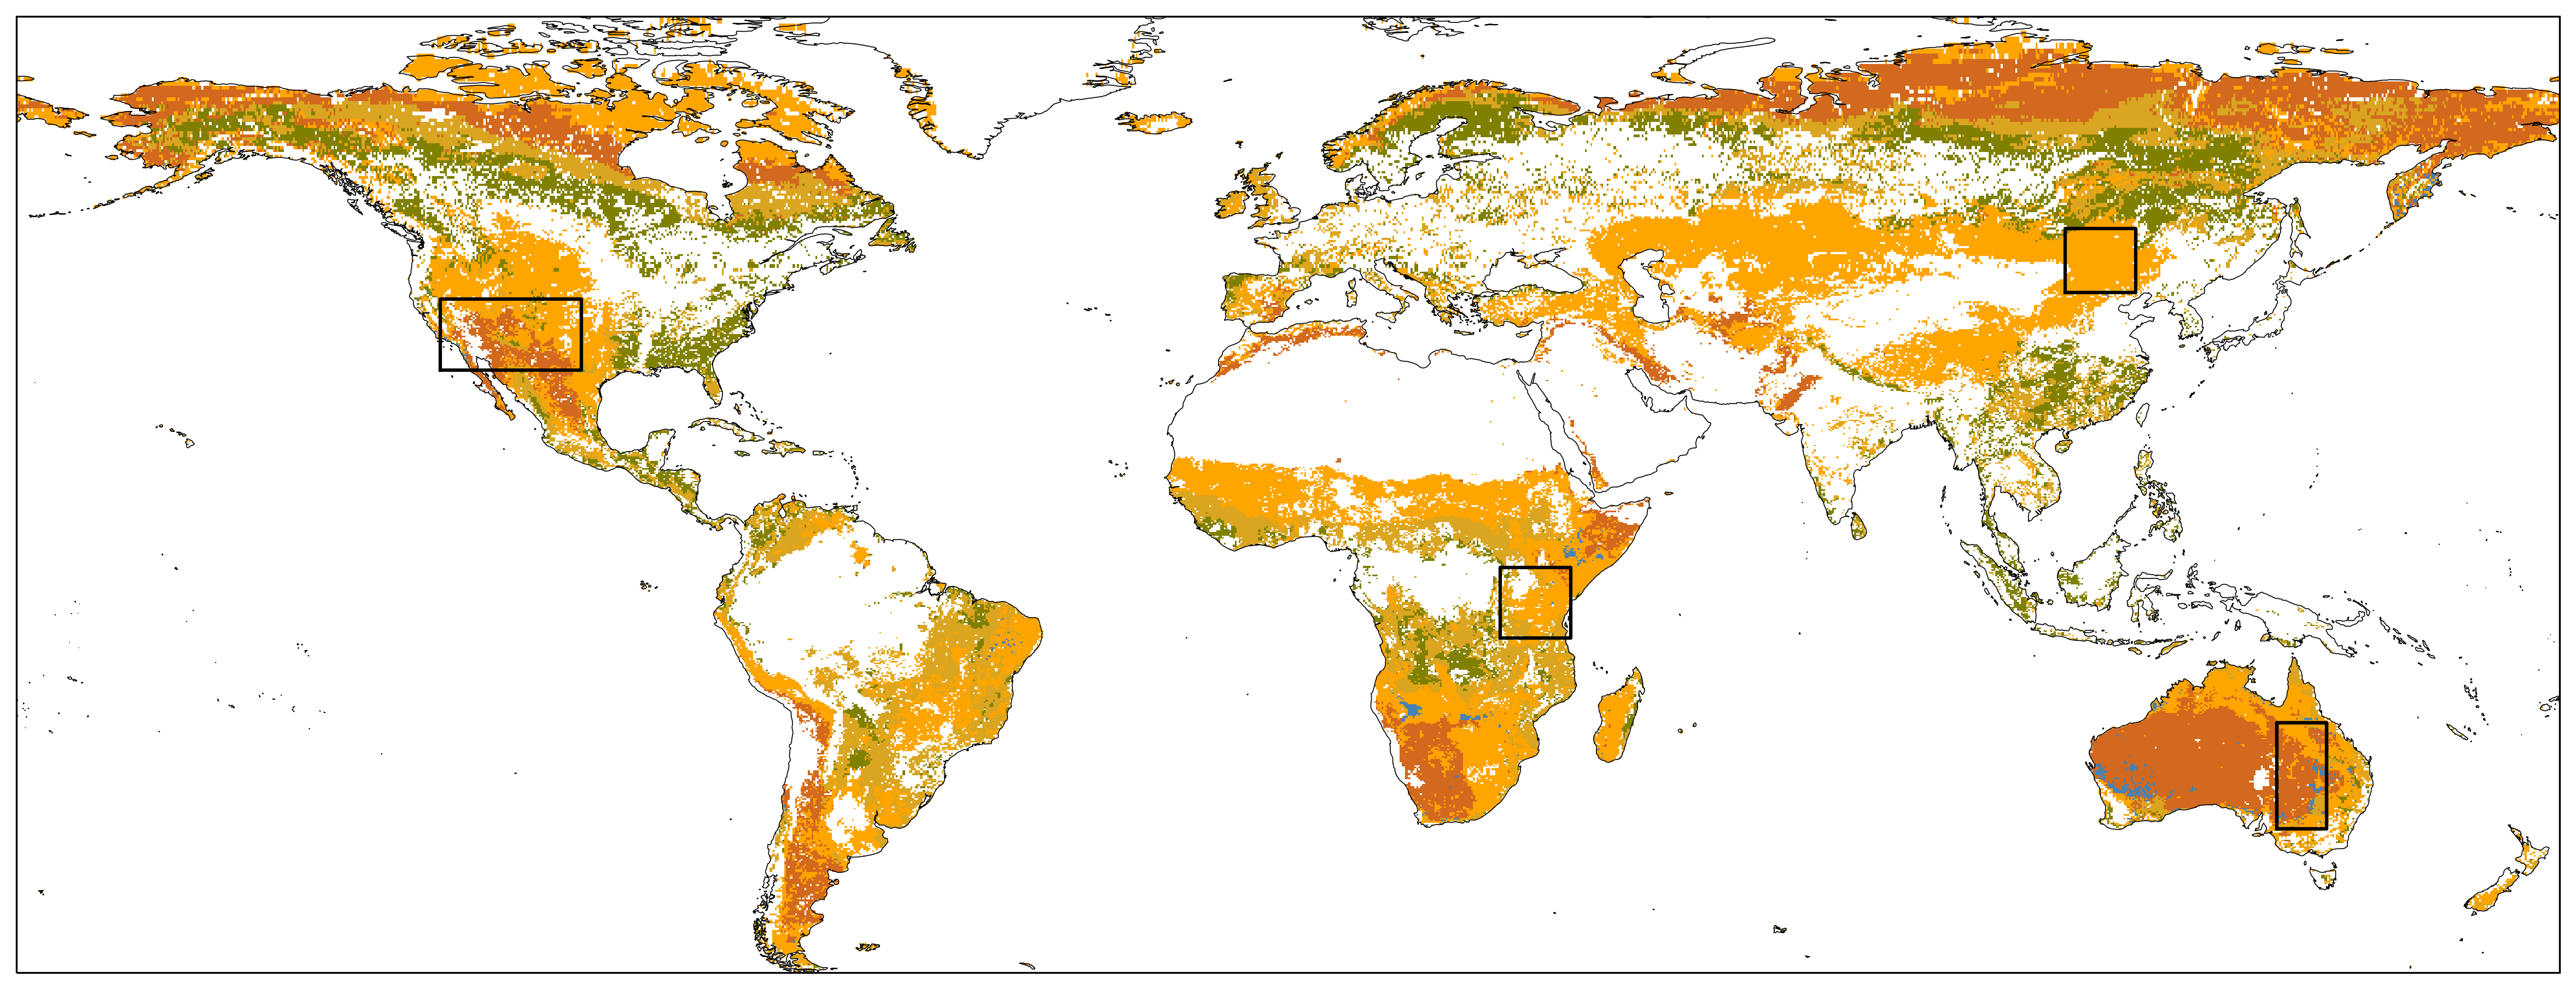

In [35]:
plt.figure(figsize=(20,10), dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, CSH, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'steelblue']), shading="nearest", label="CSH")
plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, OSH, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'chocolate']), shading="nearest", label="OSH")
plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, WSA, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'olive']), shading="nearest", label="WSA")
plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, SAV, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'goldenrod']), shading="nearest", label="SAV")
plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, GRA, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'orange']), shading="nearest", label="GRA")
#plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, GRA_SHR, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['lightgray', 'none']), shading="nearest")
#plt.pcolormesh(IGBP_ds.lon, IGBP_ds.lat, WATER, transform=ccrs.PlateCarree(), cmap=colors.ListedColormap(['none', 'lightblue']), shading="nearest")
ax.plot([-120, -100, -100, -120, -120], [30, 30, 40, 40, 30],
         color='black', linewidth=1.5, transform=ccrs.PlateCarree(),
         )

ax.plot([30, 40, 40, 30, 30], [-8, -8, 2, 2, -8],
         color='black', linewidth=1.5, transform=ccrs.PlateCarree(),
         )

ax.plot([140, 140, 147, 147, 140], [-35, -20, -20, -35, -35],
         color='black', linewidth=1.5, transform=ccrs.PlateCarree(),
         )

ax.plot([140, 140, 147, 147, 140], [-35, -20, -20, -35, -35],
         color='black', linewidth=1.5, transform=ccrs.PlateCarree(),
         )

ax.plot([110, 110, 120, 120, 110], [41, 50, 50, 41, 41],
         color='black', linewidth=1.5, transform=ccrs.PlateCarree(),
         )

ax.coastlines(linewidth=0.4, resolution="50m")


In [36]:
sm_ds = xr.open_dataset("./data/annual_sm.nc").soil_moisture
sif_ds = xr.open_dataset("./data/annual_sif.nc").clear_daily_sif
igbp_ds = xr.open_dataset("./data/annual_igbp.nc").IGBP
ai_ds = xr.open_dataset("./data/AI_EASE2.nc").AI

In [357]:
def plot_aggregate_regression(aax, SM_DS, SIF_DS):
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    aax.scatter(SM_DS.values.flatten(), SIF_DS.values.flatten(), s=0.8, alpha=0.5)
    us_mask_flat = np.invert(np.isnan(SM_DS.values.flatten())) & np.invert(np.isnan(SIF_DS.values.flatten()))
    total_reg = linregress(SM_DS.values.flatten()[us_mask_flat], SIF_DS.values.flatten()[us_mask_flat])
    aax.plot([SM_min, SM_max], [SM_min * total_reg.slope + total_reg.intercept, SM_max * total_reg.slope + total_reg.intercept], linewidth=1.5, c="k")
    aax.set_xlim(SM_min, SM_max)
    aax.set_ylim(SIF_min, SIF_max)
    aax.text((SM_max - SM_min) * 0.1 + SM_min, (SIF_max - SIF_min) * 0.9 + SIF_min, "β={:.2f}±{:.2f}".format(total_reg.slope, total_reg.stderr))
    
def plot_pixel_wise_aggregate(aax, SM_DS, SIF_DS):
    SM_pointwise_reg = []
    SM_pointwise_range = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
        for j in range(SM_DS.values.shape[2]):
            if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                reg = linregress(SM_DS.values[:, i, j], SIF_DS.values[:, i, j])
                SM_pointwise_reg.append(reg)
                SM_pointwise_range.append((np.min(SM_DS.values[:, i, j]), np.max(SM_DS.values[:, i, j])))
    
    for i in range(len(SM_pointwise_reg)):
        ymin = SM_pointwise_reg[i].slope*SM_pointwise_range[i][0]+SM_pointwise_reg[i].intercept
        ymax = SM_pointwise_reg[i].slope*SM_pointwise_range[i][1]+SM_pointwise_reg[i].intercept
        aax.plot([SM_pointwise_range[i][0], SM_pointwise_range[i][1]], [ymin, ymax], alpha=0.5, linewidth=0.6)
    mean_slope = np.nanmean([reg.slope for reg in SM_pointwise_reg])
    mean_intercept = np.nanmean([reg.intercept for reg in SM_pointwise_reg])
    aax.plot([SM_min, SM_max], [SM_min * mean_slope + mean_intercept, SM_max * mean_slope + mean_intercept], linewidth=1.5, c="k")
    aax.set_xlim(SM_min, SM_max)
    aax.set_ylim(SIF_min, SIF_max)
    aax.text((SM_max - SM_min) * 0.1 + SM_min, (SIF_max - SIF_min) * 0.9 + SIF_min, "mean β={:.2f}".format(mean_slope))
    
    
def plot_pixel_wise_lag_1_aggregate(aax, SM_DS, SIF_DS):
    SM_pointwise_reg = []
    β_1_list = []
    β_2_list = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
        for j in range(SM_DS.values.shape[2]):
            if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                X=np.array([SM_DS[1:, i, j].values, SM_DS[:-1, i,j].values]).T
                Y=SIF_DS.values[1:, i, j]
                reg = linear_model.LinearRegression()
                β_1, β_2 = reg.fit(X, Y).coef_
                β_1_list.append(β_1)
                β_2_list.append(β_2)
    
    n1, bins1, patch1 = aax.hist(β_1_list, alpha=0.5, bins=40)
    n2, bins2, patch2 = aax.hist(β_2_list, alpha=0.5, bins=40)
    # print(n1, bins1)
    mean_β_1 = np.mean(β_1_list)
    mean_β_2 = np.mean(β_2_list)
    all_bins = np.concatenate([bins1, bins2])
    x_min = np.min(all_bins)
    x_max = np.max(all_bins)
    all_n = np.concatenate([n1, n2])
    y_max = np.max(all_n)
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, r"$\beta_{t}$" + ": {:.2f}".format(mean_β_1))
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.85, r"$\beta_{t-1}$" + ": {:.2f}".format(mean_β_2))
    
def plot_pixel_wise_ai(aax, SM_DS, SIF_DS, AI_DS):
    idx_list = []
    sif_list = []
    sm_list = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
            for j in range(SM_DS.values.shape[2]):
                if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                    idx_list.append(i*SM_DS.values.shape[2]+j)
                sm_list.append(SM_DS.values[:, i, j])
                sif_list.append(SIF_DS.values[:, i, j])
    ai_flatten = AI_DS.values.flatten()

    idx_list = np.array(idx_list)
    sm_list = np.array(sm_list)
    sif_list = np.array(sif_list)
    sorted_idx = idx_list[np.argsort(ai_flatten[idx_list])]
    BINS = 40
    BIN_VALS= len(sorted_idx) // BINS 
    reg_bin_list = []
    sm_bin_list = []
    sif_bin_list = []
    for i in range(BINS):
        bin_idx = sorted_idx[i*BIN_VALS:(i+1)*BIN_VALS]
        sm_bin = sm_list[bin_idx].flatten()
        sif_bin = sif_list[bin_idx].flatten()
        reg_bin = linregress(sm_bin, sif_bin)
        reg_bin_list.append(reg_bin)

        bin_x = [np.min(sm_bin), np.max(sm_bin)]
        bin_y = [np.min(sm_bin) * reg_bin.slope + reg_bin.intercept, np.max(sm_bin) * reg_bin.slope + reg_bin.intercept]
        aax.plot(bin_x, bin_y, alpha=0.5)
    
    mean_slope = np.nanmean([reg.slope for reg in reg_bin_list])
    mean_intercept = np.nanmean([reg.intercept for reg in reg_bin_list])
    aax.plot([SM_min, SM_max], [SM_min * mean_slope + mean_intercept, SM_max * mean_slope + mean_intercept], c="k")
    aax.set_xlim(SM_min, SM_max)
    aax.set_ylim(SIF_min, SIF_max)
    aax.text((SM_max - SM_min) * 0.1 + SM_min, (SIF_max - SIF_min) * 0.9 + SIF_min, "mean β={:.2f}".format(mean_slope))
    
def plot_temporal_aggregate(aax, SM_DS, SIF_DS):
    SM_temporal_reg = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    mask_t = np.invert((np.sum(np.isnan(SM_DS.values), axis=0) > 0) | (np.sum(np.isnan(SIF_DS.values), axis=0) > 0)).flatten()
        
    for i in range(SM_DS.values.shape[0]):
        sm_t_flat = SM_DS[i, :, :].values.flatten()
        sif_t_flat = SIF_DS[i, :, :].values.flatten()
        reg = linregress(sm_t_flat[mask_t], sif_t_flat[mask_t])
        aax.plot([np.min(sm_t_flat[mask_t]), np.max(sm_t_flat[mask_t])], [np.min(sm_t_flat[mask_t]) * reg.slope + reg.intercept, np.max(sm_t_flat[mask_t]) * reg.slope + reg.intercept], alpha=0.5)
        SM_temporal_reg.append(reg)
    
    
    mean_slope = np.nanmean([reg.slope for reg in SM_temporal_reg])
    mean_intercept = np.nanmean([reg.intercept for reg in SM_temporal_reg])
    aax.plot([SM_min, SM_max], [SM_min * mean_slope + mean_intercept, SM_max * mean_slope + mean_intercept], linewidth=1.5, c="k")
    aax.set_xlim(SM_min, SM_max)
    aax.set_ylim(SIF_min, SIF_max)
    aax.text((SM_max - SM_min) * 0.1 + SM_min, (SIF_max - SIF_min) * 0.9 + SIF_min, "mean β={:.2f}".format(mean_slope))

In [358]:
idx_list = []
sif_list = []
sm_list = []
for i in range(sm_us_ds.values.shape[1]):
        for j in range(sm_us_ds.values.shape[2]):
            if np.sum(np.isnan(sm_us_ds.values[:, i, j])) == 0 and np.sum(np.isnan(sif_us_ds.values[:, i, j])) == 0:
                idx_list.append(i*sm_us_ds.values.shape[1]+j)
                sm_list.append(sm_us_ds.values[:, i, j])
                sif_list.append(sif_us_ds.values[:, i, j])
ai_flatten = ai_us_ds.values.flatten()

In [359]:
sm_us_ds = sm_ds.where((sm_ds.lon >= -120) & (sm_ds.lon <= -100) & (sm_ds.lat >= 30) & (sm_ds.lat <= 40), drop=True)
sif_us_ds = sif_ds.where((sif_ds.lon >= -120) & (sif_ds.lon <= -100) & (sif_ds.lat >= 30) & (sif_ds.lat <= 40), drop=True)
GRA_SHR_us = GRA_SHR.where((GRA_SHR.lon >= -120) & (GRA_SHR.lon <= -100) & (GRA_SHR.lat >= 30) & (GRA_SHR.lat <= 40), drop=True)
GRA_SHR_us = GRA_SHR_us.where(GRA_SHR_us==True)
sm_us_ds = sm_us_ds * GRA_SHR_us
ai_us_ds = ai_ds.where((ai_ds.lon >= -120) & (ai_ds.lon <= -100) & (ai_ds.lat >= 30) & (ai_ds.lat <= 40), drop=True)
ai_us_ds = ai_us_ds * GRA_SHR_us


sm_sr_ds = sm_ds.where((sm_ds.lon >= 30) & (sm_ds.lon <= 40) & (sm_ds.lat >= -8) & (sm_ds.lat <= 2), drop=True)
sif_sr_ds = sif_ds.where((sif_ds.lon >= 30) & (sif_ds.lon <= 40) & (sif_ds.lat >= -8) & (sif_ds.lat <= 2), drop=True)
GRA_SHR_sr = GRA_SHR.where((GRA_SHR.lon >= 30) & (GRA_SHR.lon <= 40) & (GRA_SHR.lat >= -8) & (GRA_SHR.lat <= 2), drop=True)
GRA_SHR_sr = GRA_SHR_sr.where(GRA_SHR_sr==True)
sm_sr_ds = sm_sr_ds * GRA_SHR_sr
ai_sr_ds = ai_ds.where((ai_ds.lon >= 30) & (ai_ds.lon <= 40) & (ai_ds.lat >= -8) & (ai_ds.lat <= 2), drop=True)
ai_sr_ds = ai_sr_ds * GRA_SHR_sr

sm_mo_ds = sm_ds.where((sm_ds.lon >= 110) & (sm_ds.lon <= 120) & (sm_ds.lat >= 41) & (sm_ds.lat <= 50), drop=True)
sif_mo_ds = sif_ds.where((sif_ds.lon >= 110) & (sif_ds.lon <= 120) & (sif_ds.lat >= 41) & (sif_ds.lat <= 50), drop=True)
GRA_SHR_mo = GRA_SHR.where((GRA_SHR.lon >= 110) & (GRA_SHR.lon <= 120) & (GRA_SHR.lat >= 41) & (GRA_SHR.lat <= 50), drop=True)
GRA_SHR_mo = GRA_SHR_mo.where(GRA_SHR_mo==True)
sm_mo_ds = sm_mo_ds * GRA_SHR_mo
ai_mo_ds = ai_ds.where((ai_ds.lon >= 110) & (ai_ds.lon <= 120) & (ai_ds.lat >= 41) & (ai_ds.lat <= 50), drop=True)
ai_mo_ds = ai_mo_ds * GRA_SHR_mo


sm_au_ds = sm_ds.where((sm_ds.lon >= 140) & (sm_ds.lon <= 147) & (sm_ds.lat >= -35) & (sm_ds.lat <= -20), drop=True)
sif_au_ds = sif_ds.where((sif_ds.lon >= 140) & (sif_ds.lon <= 147) & (sif_ds.lat >= -35) & (sif_ds.lat <= -20), drop=True)
GRA_SHR_au = GRA_SHR.where((GRA_SHR.lon >= 140) & (GRA_SHR.lon <= 147) & (GRA_SHR.lat >= -35) & (GRA_SHR.lat <= -20), drop=True)
GRA_SHR_au = GRA_SHR_au.where(GRA_SHR_au==True)
sm_au_ds = sm_au_ds * GRA_SHR_au
ai_au_ds = ai_ds.where((ai_ds.lon >= 140) & (ai_ds.lon <= 147) & (ai_ds.lat >= -35) & (ai_ds.lat <= -20), drop=True)
ai_au_ds = ai_au_ds * GRA_SHR_au

US_OFFSET = 5
SR_OFFSET = 10
MO_OFFSET = 15
AU_OFFSET = 20

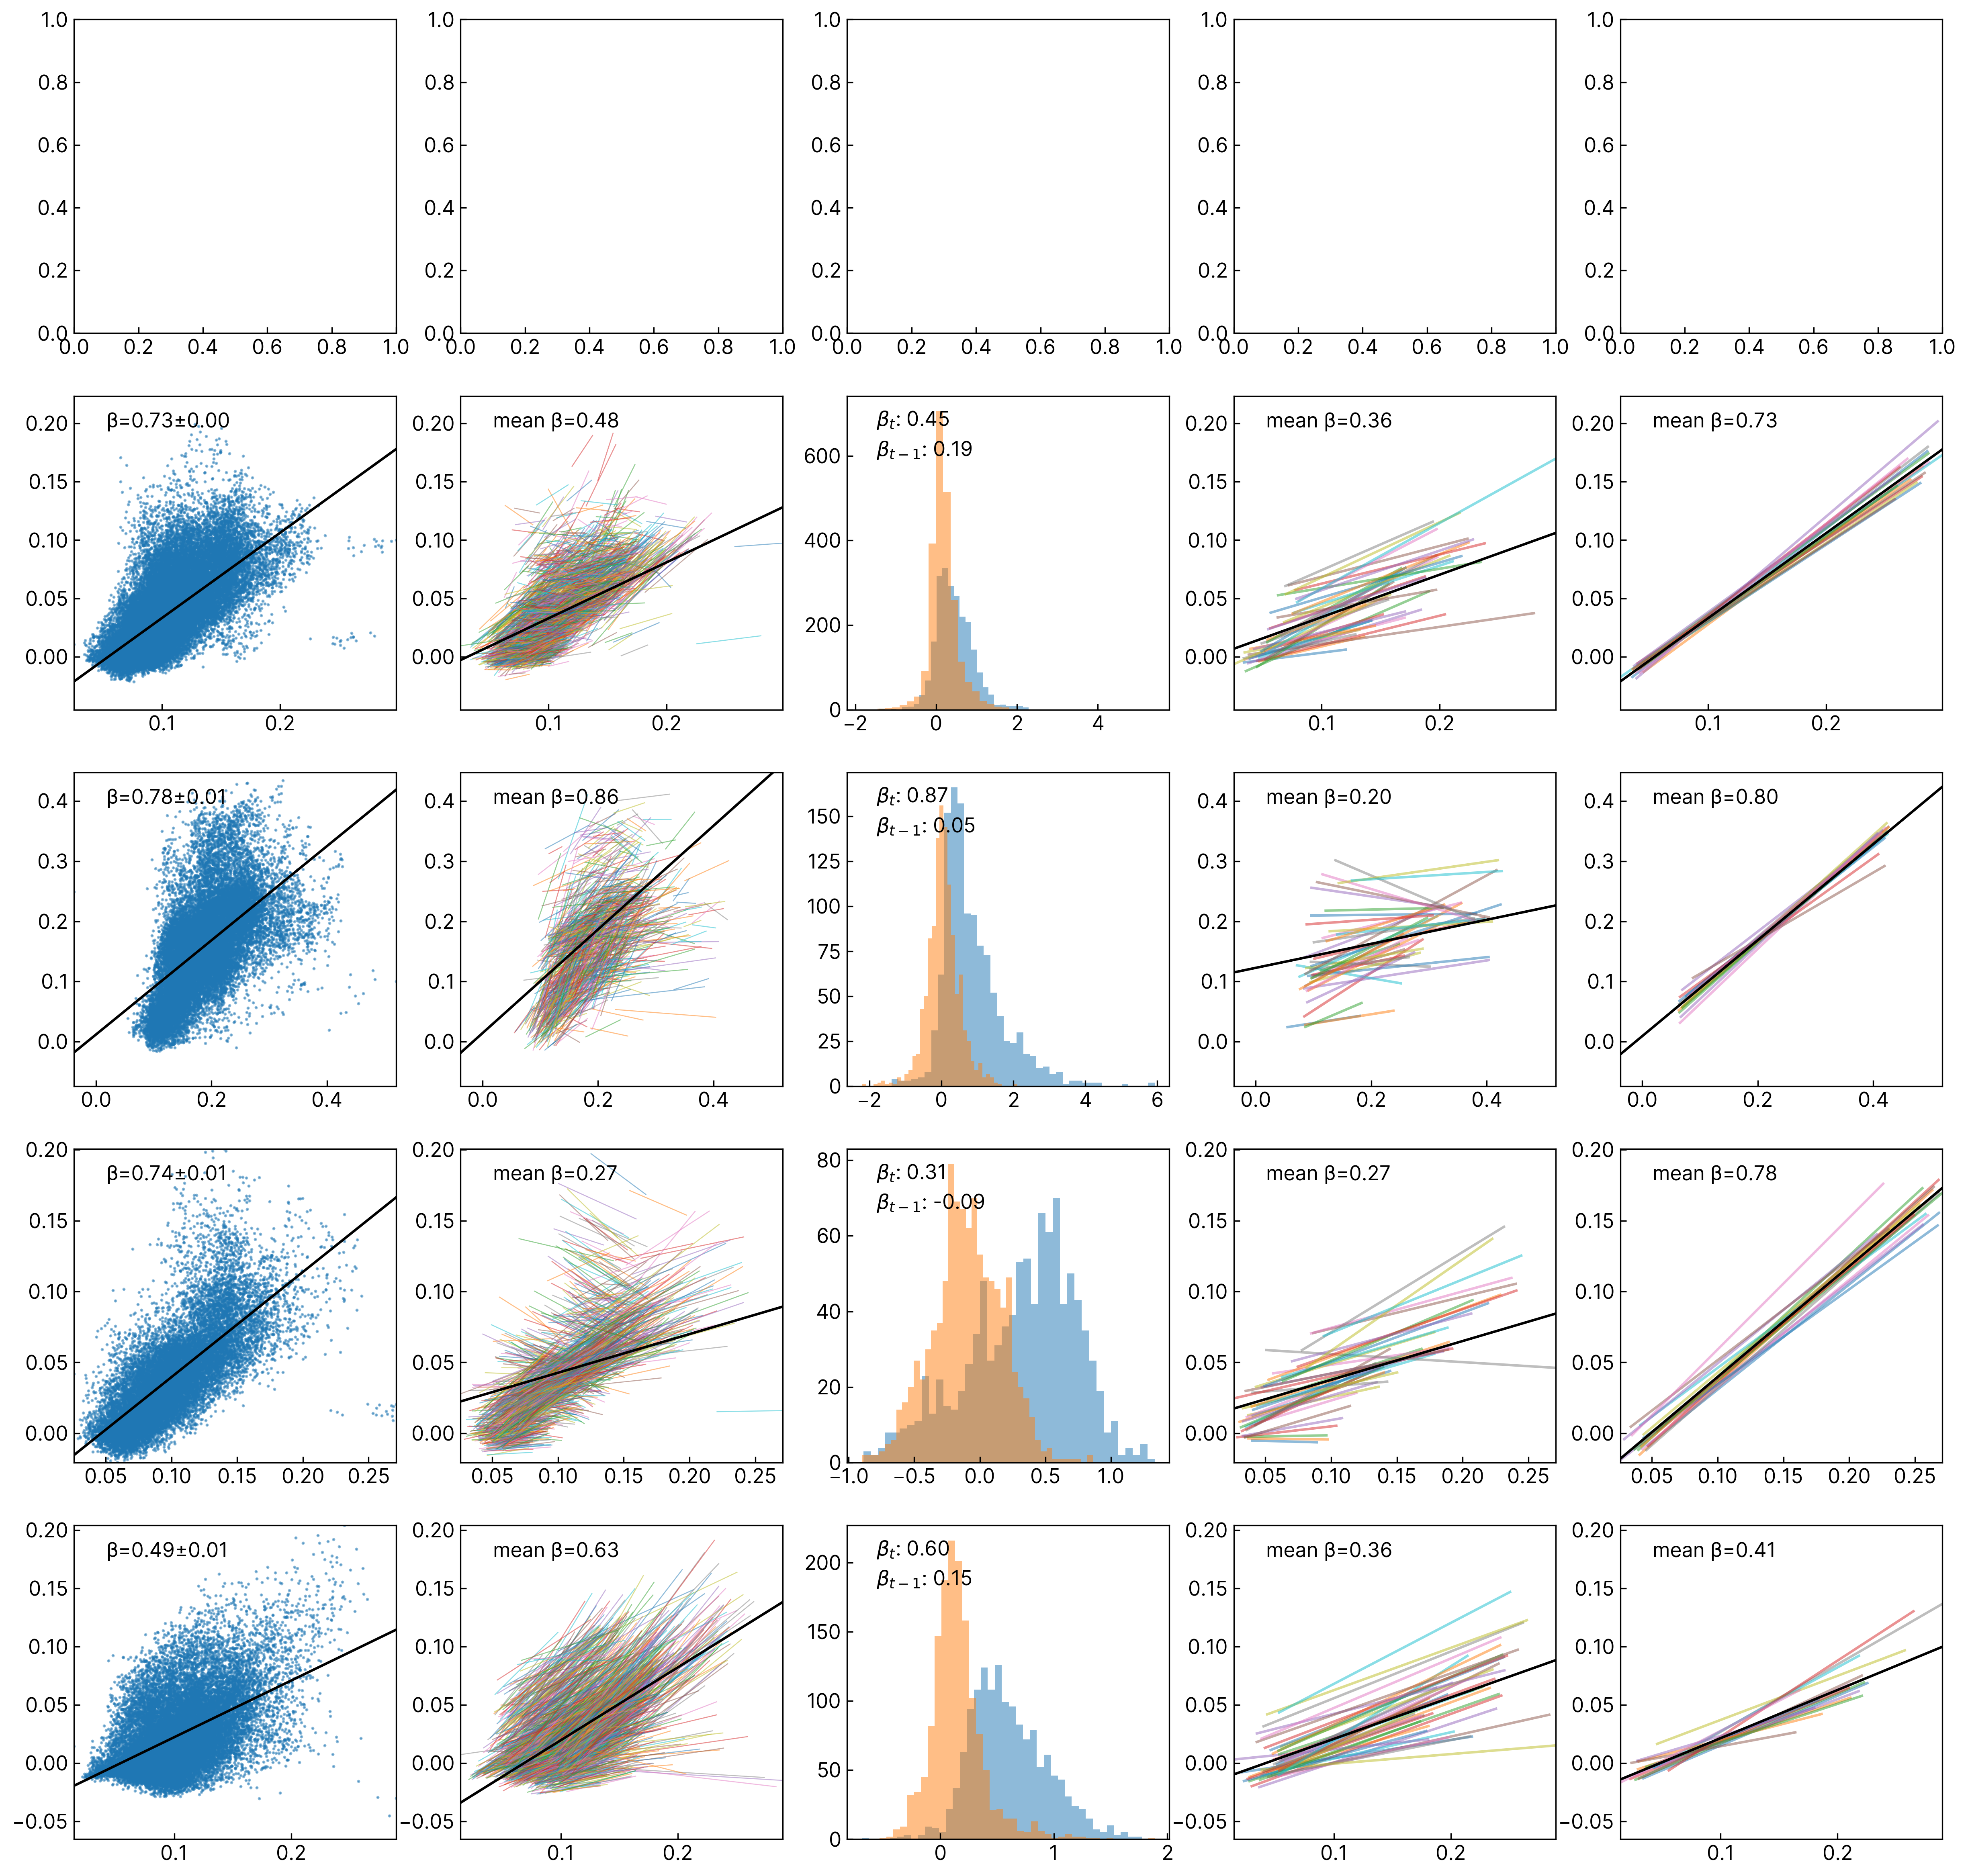

In [360]:
fig, axs = plt.subplots(5,5, figsize=(20,20))
ax = axs.flatten()

plot_aggregate_regression(ax[0 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_aggregate(ax[1 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_lag_1_aggregate(ax[2 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_ai(ax[3 + US_OFFSET], sm_us_ds, sif_us_ds, ai_us_ds)
plot_temporal_aggregate(ax[4 + US_OFFSET], sm_us_ds, sif_us_ds)

plot_aggregate_regression(ax[0 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_aggregate(ax[1 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_lag_1_aggregate(ax[2 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_ai(ax[3 + SR_OFFSET], sm_sr_ds, sif_sr_ds, ai_sr_ds)
plot_temporal_aggregate(ax[4 + SR_OFFSET], sm_sr_ds, sif_sr_ds)



plot_aggregate_regression(ax[0 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_aggregate(ax[1 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_lag_1_aggregate(ax[2 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_ai(ax[3 + MO_OFFSET], sm_mo_ds, sif_mo_ds, ai_mo_ds)
plot_temporal_aggregate(ax[4 + MO_OFFSET], sm_mo_ds, sif_mo_ds)




plot_aggregate_regression(ax[0 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_aggregate(ax[1 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_lag_1_aggregate(ax[2 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_ai(ax[3 + AU_OFFSET], sm_au_ds, sif_au_ds, ai_au_ds)
plot_temporal_aggregate(ax[4 + AU_OFFSET], sm_au_ds, sif_au_ds)




In [372]:
def plot_aggregate_regression_sig(aax, SM_DS, SIF_DS):
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)

    us_mask_flat = np.invert(np.isnan(SM_DS.values.flatten())) & np.invert(np.isnan(SIF_DS.values.flatten()))
    
    sm = SM_DS.values.flatten()[us_mask_flat]
    sif = SIF_DS.values.flatten()[us_mask_flat]
    
    N = 500
    reg_list_p = []
    for i in range(N):
        permuted_sif = np.random.permutation(sif)
        total_reg = linregress(sm, permuted_sif)
        reg_list_p.append(total_reg.slope)
    
    n1, bins1, patch1 = aax.hist(reg_list_p, bins=25, color="gray")
    
    
    SM_pointwise_reg = []
    
    for i in range(SM_DS.values.shape[1]):
        for j in range(SM_DS.values.shape[2]):
            if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                reg = linregress(SM_DS.values[:, i, j], SIF_DS.values[:, i, j])
                SM_pointwise_reg.append(reg)
    
    mean_slope = np.nanmean([reg.slope for reg in SM_pointwise_reg])
    
    aax.plot([mean_slope, mean_slope], [0, np.max(n1)], c="red")
    
    pval = min(1, 2 * min((1 + np.sum(mean_slope <= reg_list_p)) / (1 + len(reg_list_p)),
                   (1 + np.sum(mean_slope >= reg_list_p)) / (1 + len(reg_list_p))))
    
    x_min = np.min(bins1)
    x_max = np.max(bins1)
    y_max = np.max(n1)
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, "p={:.2f}".format(pval))
    
    
def plot_pixel_wise_aggregate_sig(aax, SM_DS, SIF_DS):
    SM_pointwise_reg = []
    SM_pointwise_range = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
        for j in range(SM_DS.values.shape[2]):
            if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                reg = linregress(SM_DS.values[:, i, j], SIF_DS.values[:, i, j])
                SM_pointwise_reg.append(reg)
    
    mean_slope = np.nanmean([reg.slope for reg in SM_pointwise_reg])
    
    N = 500
    perturb_list = []
    for n in range(N):
        SM_pointwise_reg_p = []
        permute = np.random.permutation(SM_DS.values.shape[0])
        for i in range(SM_DS.values.shape[1]):
            for j in range(SM_DS.values.shape[2]):
                if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                    sm = SM_DS.values[:, i, j]
                    sif = SIF_DS.values[:, i, j]
                    reg = linregress(sm, sif[permute])
                    SM_pointwise_reg_p.append(reg.slope)
        
        perturb_list.append(np.nanmean([slope for slope in SM_pointwise_reg_p]))
        
    n1, bins1, patch1 = aax.hist(perturb_list, bins=25, color="gray")
    aax.plot([mean_slope, mean_slope], [0, np.max(n1)], c="red")
    
    pval = min(1, 2 * min((1 + np.sum(mean_slope <= perturb_list)) / (1 + len(perturb_list)),
                   (1 + np.sum(mean_slope >= perturb_list)) / (1 + len(perturb_list))))
    
    x_min = np.min(bins1)
    x_max = np.max(bins1)
    y_max = np.max(n1)
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, "p={:.2f}".format(pval))
    
    
def plot_pixel_wise_lag_1_aggregate_sig(aax, SM_DS, SIF_DS):
    SM_pointwise_reg = []
    β_1_list = []
    β_2_list = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
        for j in range(SM_DS.values.shape[2]):
            if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                X=np.array([SM_DS[1:, i, j].values, SM_DS[:-1, i,j].values]).T
                Y=SIF_DS.values[1:, i, j]
                reg = linear_model.LinearRegression()
                β_1, β_2 = reg.fit(X, Y).coef_
                β_1_list.append(β_1)
                β_2_list.append(β_2)
    mean_β_1 = np.mean(β_1_list)
    mean_β_2 = np.mean(β_2_list)
    
    beta_1_permute_list = []
    beta_2_permute_list = []
    
    N=500
    for i in range(N):
        permute = np.random.permutation(SM_DS.values.shape[0] -1)
        b1p=[]
        b2p=[]
        for i in range(SM_DS.values.shape[1]):
            for j in range(SM_DS.values.shape[2]):
                if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                    X=np.array([SM_DS[1:, i, j].values, SM_DS[:-1, i,j].values]).T
                    Y=SIF_DS.values[1:, i, j]
                    reg = linear_model.LinearRegression()
                    β_1, β_2 = reg.fit(X, Y[permute]).coef_
                    b1p.append(β_1)
                    b2p.append(β_2)
        beta_1_permute_list.append(np.mean(b1p))
        beta_2_permute_list.append(np.mean(b2p))
        
        
    pval_1 = min(1, 2 * min((1 + np.sum(mean_β_1 <= beta_1_permute_list)) / (1 + len(beta_1_permute_list)),
                   (1 + np.sum(mean_β_1 >= beta_1_permute_list)) / (1 + len(beta_1_permute_list))))
    
    pval_2 = min(1, 2 * min((1 + np.sum(mean_β_2 <= beta_2_permute_list)) / (1 + len(beta_2_permute_list)),
                   (1 + np.sum(mean_β_2 >= beta_2_permute_list)) / (1 + len(beta_2_permute_list))))
        
    n1, bins1, patch1 = aax.hist(beta_1_permute_list, bins=25, color='#1f77b4', alpha=0.5)
    aax.plot([mean_β_1, mean_β_1], [0, np.max(n1)], c='#1f77b4')
    
    n2, bins2, patch2 = aax.hist(beta_2_permute_list, bins=25, color='#ff7f0e', alpha=0.5)
    aax.plot([mean_β_2, mean_β_2], [0, np.max(n2)], c='#ff7f0e')

    all_bins = np.concatenate([bins1, bins2])
    x_min = np.min(all_bins)
    x_max = np.max(all_bins)
    all_n = np.concatenate([n1, n2])
    y_max = np.max(all_n)
    
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, r"$p_{t}$"+"={:.2f}".format(pval_1))
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.85, r"$p_{t-1}$"+"={:.2f}".format(pval_2))
    
    
def plot_pixel_wise_ai_sig(aax, SM_DS, SIF_DS, AI_DS):
    idx_list = []
    sif_list = []
    sm_list = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    for i in range(SM_DS.values.shape[1]):
            for j in range(SM_DS.values.shape[2]):
                if np.sum(np.isnan(SM_DS.values[:, i, j])) == 0 and np.sum(np.isnan(SIF_DS.values[:, i, j])) == 0:
                    idx_list.append(i*SM_DS.values.shape[2]+j)
                sm_list.append(SM_DS.values[:, i, j])
                sif_list.append(SIF_DS.values[:, i, j])
    ai_flatten = AI_DS.values.flatten()

    idx_list = np.array(idx_list)
    sm_list = np.array(sm_list)
    sif_list = np.array(sif_list)
    sorted_idx = idx_list[np.argsort(ai_flatten[idx_list])]
    BINS = 40
    BIN_VALS= len(sorted_idx) // BINS 
    reg_bin_list = []
    sm_bin_list = []
    sif_bin_list = []
    for i in range(BINS):
        bin_idx = sorted_idx[i*BIN_VALS:(i+1)*BIN_VALS]
        sm_bin = sm_list[bin_idx].flatten()
        sif_bin = sif_list[bin_idx].flatten()
        reg_bin = linregress(sm_bin, sif_bin)
        reg_bin_list.append(reg_bin)
    
    mean_slope = np.nanmean([reg.slope for reg in reg_bin_list])

        
    N = 500
    all_reg_bin_p = []
    for n in range(N):
        reg_bin_list_p = []
        permute = np.random.permutation(BIN_VALS * SM_DS.values.shape[0])
        for i in range(BINS):
            bin_idx = sorted_idx[i*BIN_VALS:(i+1)*BIN_VALS]
            sm_bin = sm_list[bin_idx].flatten()
            sif_bin = sif_list[bin_idx].flatten()
            
            reg_bin = linregress(sm_bin, sif_bin[permute])
            
            reg_bin_list_p.append(reg_bin)
        all_reg_bin_p.append(np.nanmean(reg_bin_list_p))
    
    n1, bins1, patch1 = aax.hist(all_reg_bin_p, bins=25, color="gray")
    aax.plot([mean_slope, mean_slope], [0, np.max(n1)], c="red")
    
    pval = min(1, 2 * min((1 + np.sum(mean_slope <= all_reg_bin_p)) / (1 + len(all_reg_bin_p)),
                   (1 + np.sum(mean_slope >= all_reg_bin_p)) / (1 + len(all_reg_bin_p))))
    
    x_min = np.min(bins1)
    x_max = np.max(bins1)
    y_max = np.max(n1)
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, "p={:.2f}".format(pval))
        

def plot_temporal_aggregate_sig(aax, SM_DS, SIF_DS):
    SM_temporal_reg = []
    
    SM_min = np.nanmin(SM_DS.values)
    SM_max = np.nanmax(SM_DS.values)
    SIF_min = np.nanmin(SIF_DS.values)
    SIF_max = np.nanmax(SIF_DS.values)
    
    mask_t = np.invert((np.sum(np.isnan(SM_DS.values), axis=0) > 0) | (np.sum(np.isnan(SIF_DS.values), axis=0) > 0)).flatten()
    
    for i in range(SM_DS.values.shape[0]):
        sm_t_flat = SM_DS[i, :, :].values.flatten()
        sif_t_flat = SIF_DS[i, :, :].values.flatten()
        reg = linregress(sm_t_flat[mask_t], sif_t_flat[mask_t])
        SM_temporal_reg.append(reg)
    
    mean_slope = np.nanmean([reg.slope for reg in SM_temporal_reg])
    
    N = 500
    SM_temporal_reg_p = []
    for n in range(N):
        SM_temporal_reg_per = []
        permute = np.random.permutation(np.sum(mask_t))
        for i in range(SM_DS.values.shape[0]):
            sm_t_flat = SM_DS[i, :, :].values.flatten()
            sif_t_flat = SIF_DS[i, :, :].values.flatten()
            reg = linregress(sm_t_flat[mask_t], (sif_t_flat[mask_t])[permute])
            SM_temporal_reg_per.append(reg.slope)
        SM_temporal_reg_p.append(np.nanmean(SM_temporal_reg_per))
    n1, bins1, patch1 = aax.hist(SM_temporal_reg_p, bins=25, color="gray")
    aax.plot([mean_slope, mean_slope], [0, np.max(n1)], c="red")
    pval = min(1, 2 * min((1 + np.sum(mean_slope <= SM_temporal_reg_p)) / (1 + len(SM_temporal_reg_p)),
                   (1 + np.sum(mean_slope >= SM_temporal_reg_p)) / (1 + len(SM_temporal_reg_p))))
               
    x_min = np.min(bins1)
    x_max = np.max(bins1)
    y_max = np.max(n1)
    aax.text((x_max-x_min) * 0.05 + x_min ,y_max * 0.95, "p={:.2f}".format(pval))
        

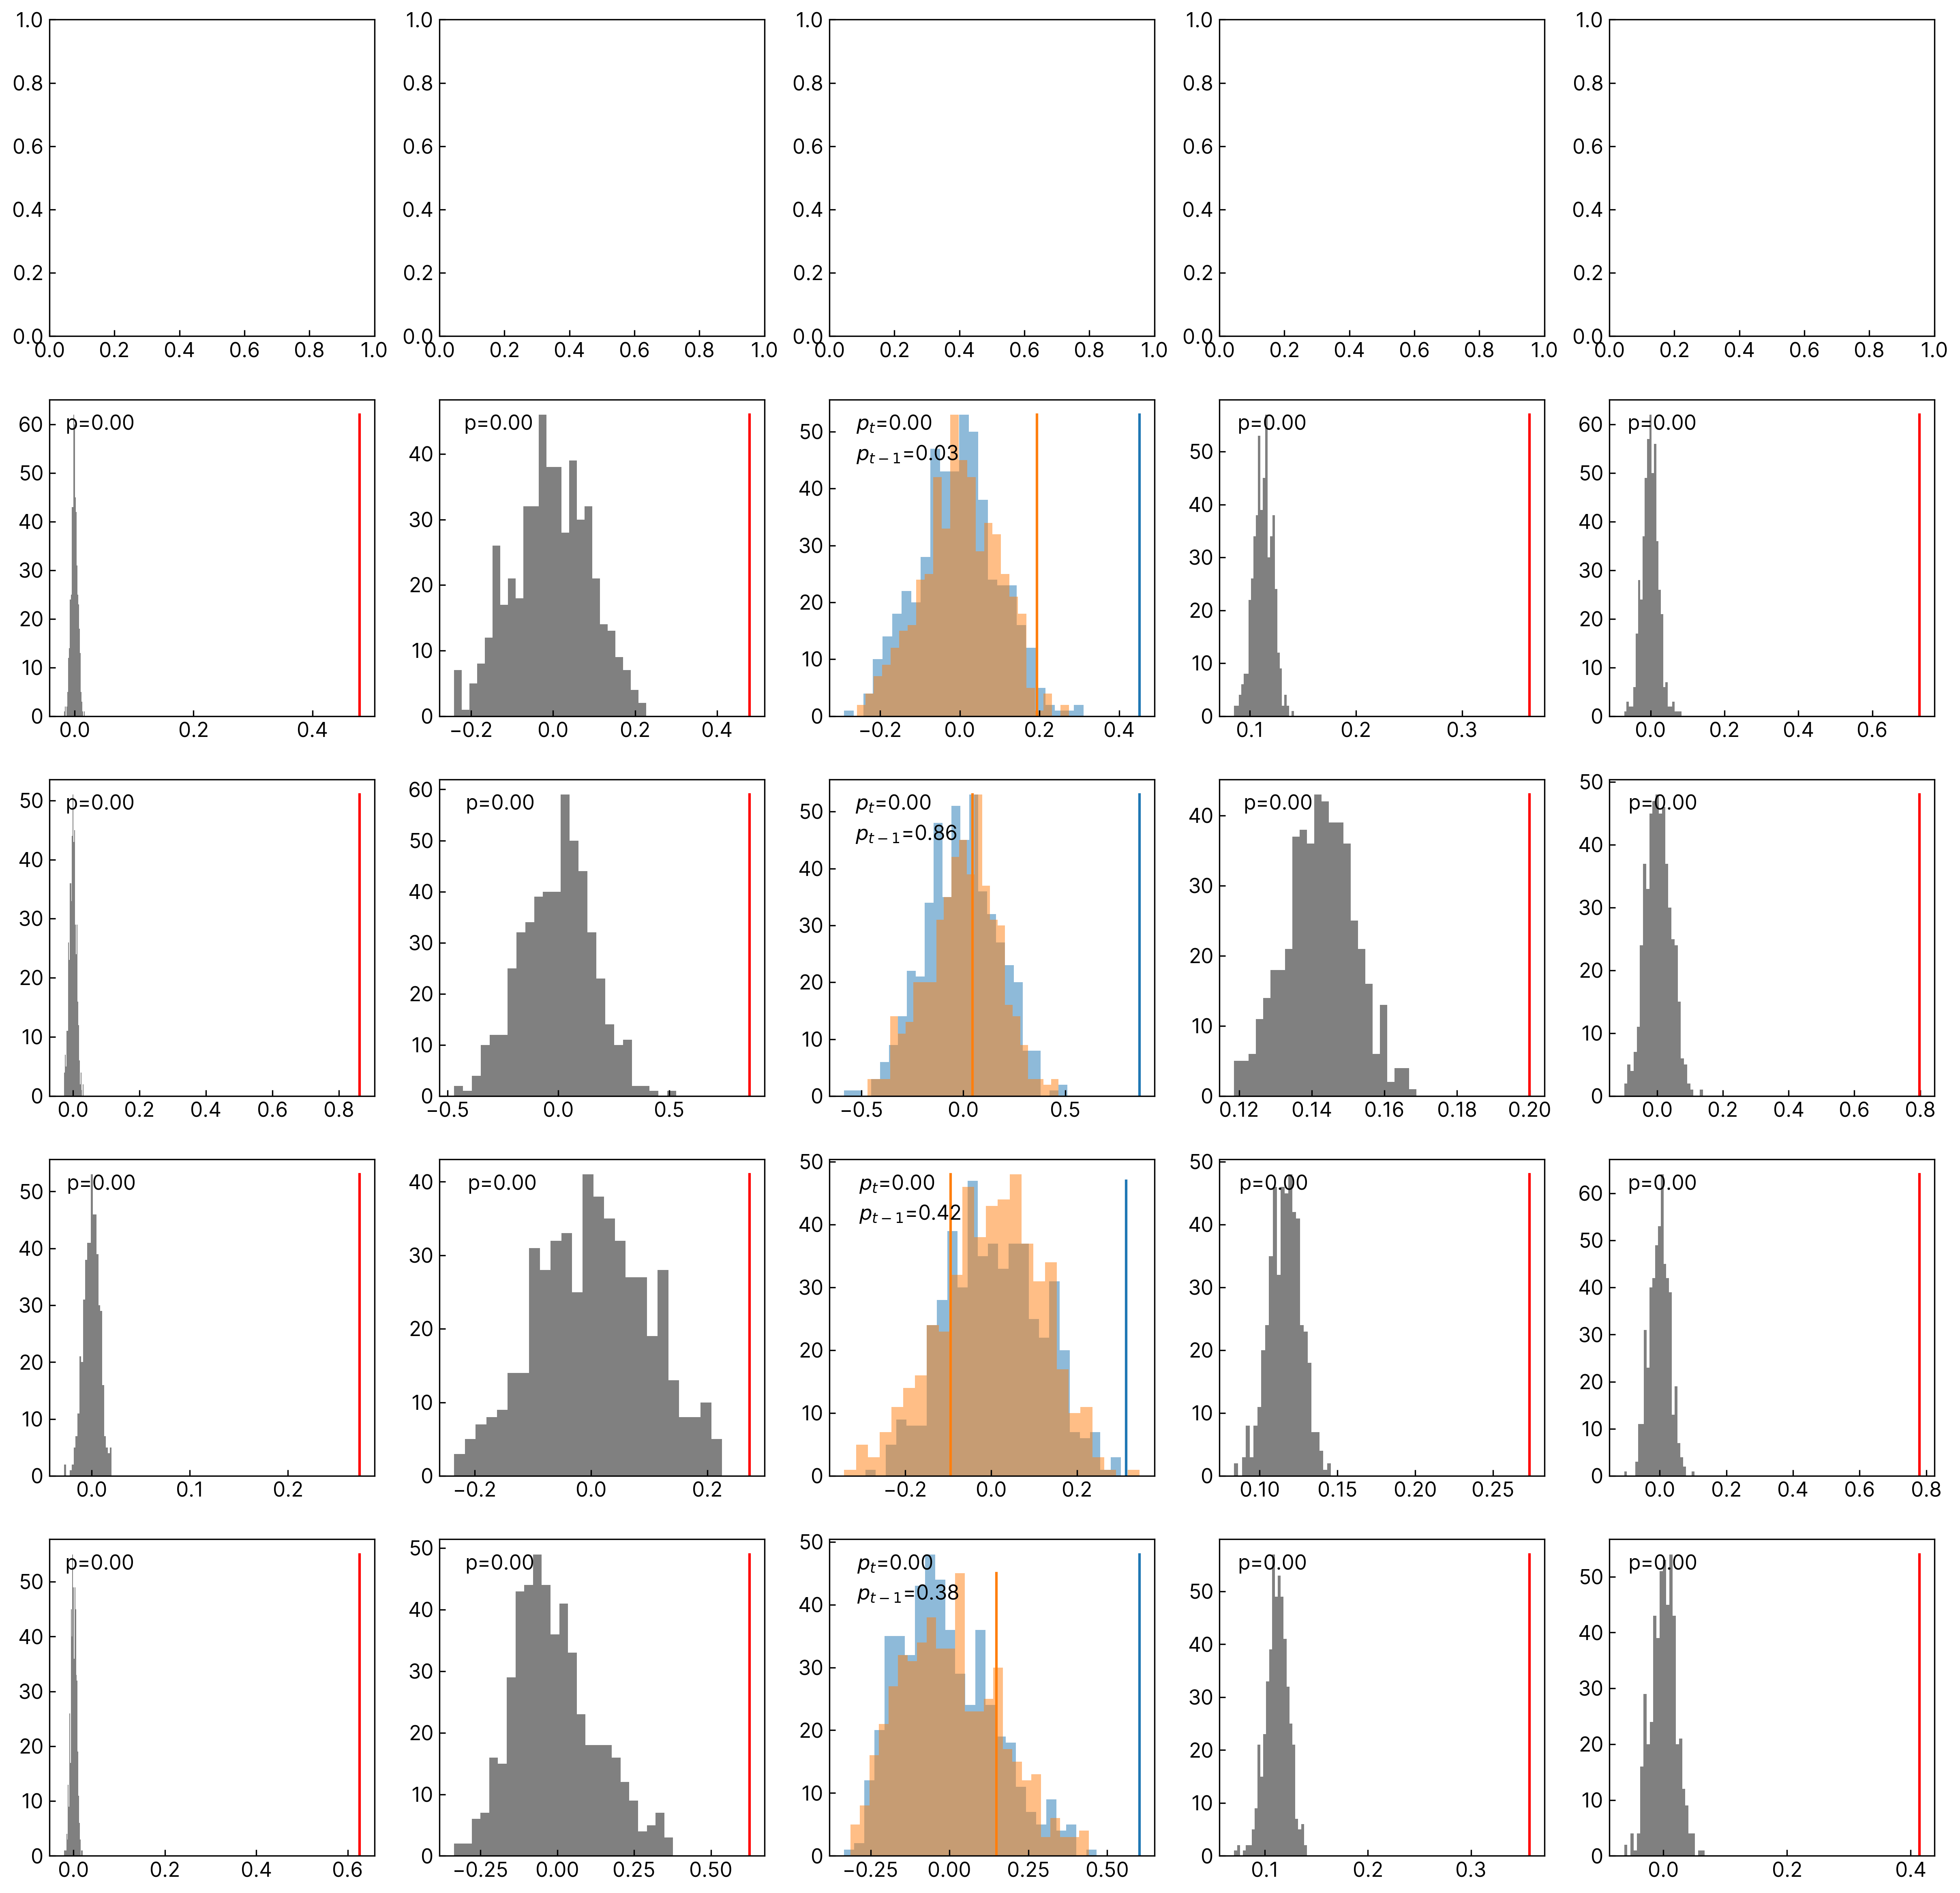

In [373]:
fig, axs = plt.subplots(5,5, figsize=(20,20))
ax = axs.flatten()

plot_aggregate_regression_sig(ax[0 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_aggregate_sig(ax[1 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_lag_1_aggregate_sig(ax[2 + US_OFFSET], sm_us_ds, sif_us_ds)
plot_pixel_wise_ai_sig(ax[3 + US_OFFSET], sm_us_ds, sif_us_ds, ai_us_ds)
plot_temporal_aggregate_sig(ax[4 + US_OFFSET], sm_us_ds, sif_us_ds)


plot_aggregate_regression_sig(ax[0 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_aggregate_sig(ax[1 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_lag_1_aggregate_sig(ax[2 + SR_OFFSET], sm_sr_ds, sif_sr_ds)
plot_pixel_wise_ai_sig(ax[3 + SR_OFFSET], sm_sr_ds, sif_sr_ds, ai_sr_ds)
plot_temporal_aggregate_sig(ax[4 + SR_OFFSET], sm_sr_ds, sif_sr_ds)


plot_aggregate_regression_sig(ax[0 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_aggregate_sig(ax[1 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_lag_1_aggregate_sig(ax[2 + MO_OFFSET], sm_mo_ds, sif_mo_ds)
plot_pixel_wise_ai_sig(ax[3 + MO_OFFSET], sm_mo_ds, sif_mo_ds, ai_mo_ds)
plot_temporal_aggregate_sig(ax[4 + MO_OFFSET], sm_mo_ds, sif_mo_ds)

plot_aggregate_regression_sig(ax[0 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_aggregate_sig(ax[1 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_lag_1_aggregate_sig(ax[2 + AU_OFFSET], sm_au_ds, sif_au_ds)
plot_pixel_wise_ai_sig(ax[3 + AU_OFFSET], sm_au_ds, sif_au_ds, ai_au_ds)
plot_temporal_aggregate_sig(ax[4 + AU_OFFSET], sm_au_ds, sif_au_ds)